# Imported Libraries

In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import tf_keras
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score,accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Helper Functions

In [11]:
def process_and_load_data(data = pd.DataFrame, target = str):
    #The input should only be a Pandas DataFrame 
 
    #This creates split datasets for training, testing, and validation
    #Additionally it prepares the input data sets for model fitting and predicting
   
    data.rename(columns = {"Coronary heart disease": "Coronary_heart_disease"}, inplace=True)
    


    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)



    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_data, label=target)
    val_ds = tfdf.keras.pd_dataframe_to_tf_dataset(val_data, label=target)
    test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, label=target)


    return train_ds, test_ds, val_ds

# Data Loading and Processing

In [12]:
df = pd.read_parquet('data/nhanes_data_processed.parquet')
df.head()

,Weight,Body mass index,Systolic,Diastolic,Gender,Age,Diabetes,Glycohemoglobin,Cholesterol,High-density lipoprotein (HDL),...,Basophils,Red blood cells,Hemoglobin,Red blood cell width,Platelet count,Mean volume of platelets,Coronary heart disease,Blood related diabetes,Moderate-work,Vigorous-work
4,92.5,29.10,122.0,82.0,Male,597.0,No,5.5,7.21,1.08,...,5.397605e-79,5.13,14.5,13.1,209.0,10.4,No,No,17.0,Yes
6,78.0,29.39,130.0,78.0,Female,712.0,No,5.8,6.34,2.73,...,5.397605e-79,4.60,13.4,14.3,244.0,8.2,No,Yes,3.0,No
9,111.8,30.94,152.0,98.0,Male,518.0,No,5.5,3.62,1.31,...,5.397605e-79,5.00,15.4,13.7,167.0,9.4,No,Don't know,13.0,Don't know
13,75.5,27.33,142.0,56.0,Male,973.0,No,5.8,4.50,1.04,...,5.397605e-79,5.32,16.6,12.4,160.0,9.0,No,No,9.0,Yes
14,81.6,26.68,106.0,68.0,Female,459.0,No,4.6,5.15,1.49,...,5.397605e-79,4.14,13.3,11.9,255.0,7.7,No,No,13.0,Yes


In [13]:
# Male = 1
# Female = 0
# CHD Positive = 1
# CHD Negative = 1
#df['Gender'] = df['Gender'].mask(df['Gender'] == 'Male', 1).mask(df['Gender'] == 'Female', 0)
df['Coronary heart disease'] = df['Coronary heart disease'].mask(df['Coronary heart disease'] == 'Yes', 1).mask(df['Coronary heart disease'] == 'No', 0)
categorical_cols = ['Diabetes', 'Blood related diabetes', 'Vigorous-work']

# One-hot encoding
#df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

#Correct Data Type
df['Coronary heart disease'] = df['Coronary heart disease'].astype(int)

In [16]:
train_ds, test_ds, val_ds = process_and_load_data(df, 'Coronary_heart_disease')

# Base Line Decision Tree Model

In [18]:
rf = tfdf.keras.RandomForestModel(verbose=2)

Use 16 thread(s) for training
Use /tmp/tmpounxowq_ as temporary training directory


In [19]:
rf.fit(train_ds)

Reading training dataset...
Training tensor examples:
Features: {'Weight': <tf.Tensor 'data:0' shape=(None,) dtype=float64>, 'Body_mass_index': <tf.Tensor 'data_1:0' shape=(None,) dtype=float64>, 'Systolic': <tf.Tensor 'data_2:0' shape=(None,) dtype=float64>, 'Diastolic': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'Gender': <tf.Tensor 'data_4:0' shape=(None,) dtype=string>, 'Age': <tf.Tensor 'data_5:0' shape=(None,) dtype=float64>, 'Diabetes': <tf.Tensor 'data_6:0' shape=(None,) dtype=string>, 'Glycohemoglobin': <tf.Tensor 'data_7:0' shape=(None,) dtype=float64>, 'Cholesterol': <tf.Tensor 'data_8:0' shape=(None,) dtype=float64>, 'High-density_lipoprotein_(HDL)': <tf.Tensor 'data_9:0' shape=(None,) dtype=float64>, 'Albumin': <tf.Tensor 'data_10:0' shape=(None,) dtype=float64>, 'Alanine_aminotransferase_(ALT)': <tf.Tensor 'data_11:0' shape=(None,) dtype=float64>, 'Aspartate_aminotransferase_(AST)': <tf.Tensor 'data_12:0' shape=(None,) dtype=float64>, 'Alkaline_phosphatase_(ALP)'

# Evaluation

In [20]:
rf.compile(metrics=["accuracy"])
evaluation = rf.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

10/10 [==============================] - 1s 28ms/step - loss: 0.0000e+00 - accuracy: 0.9595

loss: 0.0000
accuracy: 0.9595


In [23]:
rf.summary()

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (34):
	Age
	Alanine_aminotransferase_(ALT)
	Albumin
	Alkaline_phosphatase_(ALP)
	Aspartate_aminotransferase_(AST)
	Basophils
	Bilirubin
	Blood_related_diabetes
	Body_mass_index
	Cholesterol
	Creatinine
	Diabetes
	Diastolic
	Gamma-glutamyl_transferase_(GGT)
	Gender
	Glucose
	Glycohemoglobin
	Hemoglobin
	High-density_lipoprotein_(HDL)
	Iron
	Lactate_dehydrogenase_(LDH)
	Mean_volume_of_platelets
	Moderate-work
	Phosphorus
	Platelet_count
	Protein
	Red_blood_cell_width
	Red_blood_cells
	Systolic
	Triglycerides
	Uric_acid
	Vigorous-work
	Weight
	White_blood_cells

No weights

Variable Importance: IN

In [24]:
rf.make_inspector().evaluation()

Evaluation(num_examples=27492, accuracy=0.9583878946602647, loss=0.28823522435378657, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

Text(0, 0.5, 'Logloss (out-of-bag)')

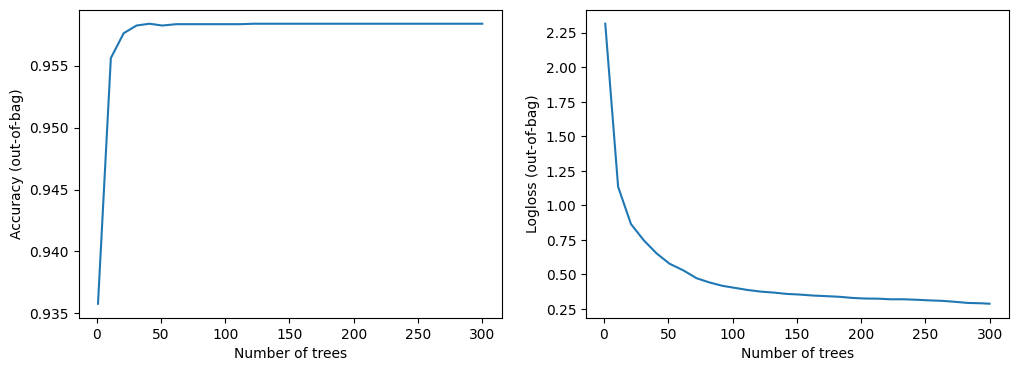

In [26]:
logs = rf.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")


In [27]:
rf.compile(metrics=["accuracy"])
evaluation = rf.evaluate(val_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

10/10 [==============================] - 0s 28ms/step - loss: 0.0000e+00 - accuracy: 0.9615

loss: 0.0000
accuracy: 0.9615
